In [7]:
import torch as th
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
from papersim.sim_modules import Module, Transition
from papersim.risk_generator import Risk, RiskGen

## Model parametrization

In [9]:
def run_sim(riskgen, sc, prod_tensor, t_run):
    inventory = th.zeros(t_run, 2, 3, 3)
    produced = th.zeros(t_run, 1, 3, 3)

    for i in range(t_run):
        riskgen.step()
        # risks
        for mod in sc:
            if isinstance(mod, Module):
                mod.current_capacity = riskgen.get_cap_i(mod.mod_idx)
                prod_tensor, num_produced = mod.process(prod_tensor)
                produced[i, 0, mod.mod_idx, mod.prod_idx] = num_produced
            elif isinstance(mod, Transition):
                mod.current_capacity = riskgen.get_cap_i(mod.idx)
                prod_tensor = mod.process(prod_tensor)

        #print(produced[i])

        inventory[i] = prod_tensor

    return inventory, produced

In [29]:
prod_matrix = th.tensor([[0, 0, 0],
                         [0, 0, 0],
                         [1, 1, 0]], dtype=th.int32)

mod_a = Module(0, 0, prod_matrix[0], 10)
mod_b = Module(1, 1, prod_matrix[1], 10)
mod_c = Module(2, 2, prod_matrix[2], 10)

tra_ac = Transition(3, 0, 2, 0, 10)
tra_bc = Transition(4, 1, 2, 1, 10)

sc = [mod_a, tra_ac, mod_b, tra_bc, mod_c]

risks = [(0.01, 0.5, 50, [0]), # Software brakedown, once a year
         ((1/7)*1e-5, 0.2, 1, [1]), #
         (0.1, 0.2, 5, [2, 3]),
         (0.002, 0.9, 30, [0, 1, 4]),
         (0.02, 0.3, 1, [2, 3]),
         (0.1, 0.05, 10, [1, 2]),
]

## Run and plot

In [30]:
def get_current_risks(risks, i):
    current_risks = []

    for j, risk_args in enumerate(risks, 0):
        if j != i:
            current_risks.append(risk_args)

    print(current_risks)

    for j in range(len(current_risks)):
        current_risks[j] = Risk(*current_risks[j])

    return current_risks

[(1.4285714285714286e-06, 0.2, 1, [1])]


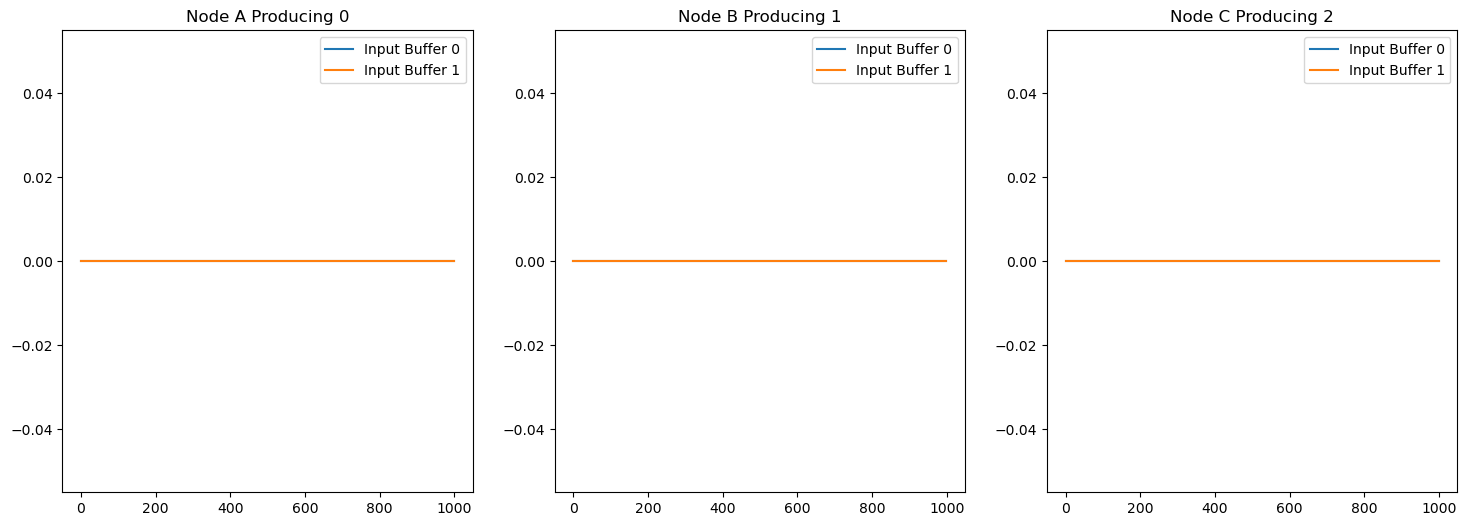

[(0.01, 0.5, 50, [0])]


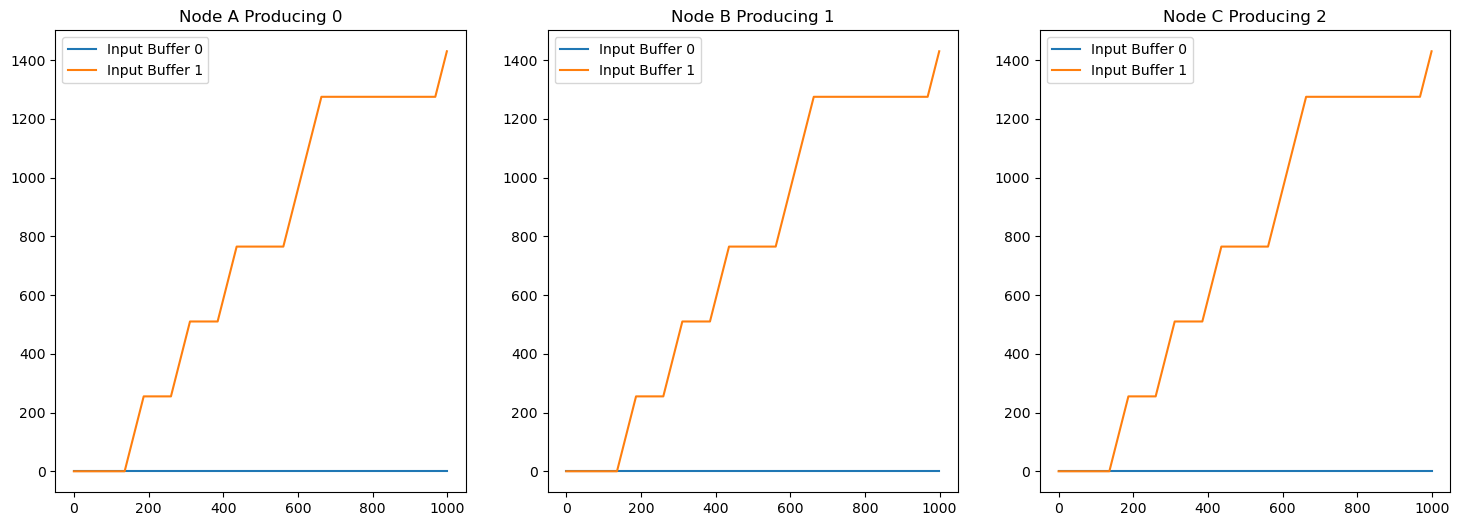

In [48]:


t_run = 1000

for k in range(len(risks)):
    prod_tensor = th.zeros(2, 3, 3, dtype=th.int32)

    current_risks = get_current_risks(risks, k)
    current_riskgen = RiskGen(current_risks, 5)

    print(current_risks)

    inventory, produced = run_sim(current_riskgen, sc, prod_tensor, t_run)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    label = ['A', 'B', 'C']
    #
    for i in range(3):

        axs[i].plot(inventory[:, 0, 2, 0:2], label=['Input Buffer 0', 'Input Buffer 1'])
        # axs[i].plot(produced[:, 0, i, 0], label='Production', color='red')
        #
        # if i != 2:
        #     axs[i].plot(inventory[:, 1, i, i], label='Output Buffer')
        axs[i].set_title("Node " + label[i] + ' Producing ' + str(i))
        axs[i].legend()

    plt.show()

        #     if i == 2:
        #     axs[i].plot(inventory[:, 0, i, 0:2], label=['Input Buffer 0', 'Input Buffer 1'])
        # axs[i].plot(produced[:, 0, i, 0], label='Production', color='red')
        #
        # if i != 2:
        #     axs[i].plot(inventory[:, 1, i, i], label='Output Buffer')
        # axs[i].set_title("Node " + label[i] + ' Producing ' + str(i))
        # axs[i].legend()